In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, plot_importance
from sklearn import metrics
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Data exploration

In [2]:
data = pd.read_csv('ipl_data.csv')

In [3]:
data

,season,team,is_format_playoffs_next,country_next,is_mega_auction_next,last_qual_years,is_captain_overseas_next,final_position,matches,position,...,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_winless_streak_2nd_half,final_position_next,in_next_playoffs,is_next_champion
0,2008,Rajasthan Royals,0,South Africa,0,1,1,1,14,1,...,1,0,12,0.835,2,6,1,6.0,0.0,0.0
1,2008,Chennai Super Kings,0,South Africa,0,1,0,2,14,3,...,3,0,8,-0.394,5,2,2,4.0,1.0,0.0
2,2008,Punjab Kings,0,South Africa,0,1,0,3,14,2,...,2,0,10,0.591,3,4,1,5.0,0.0,0.0
3,2008,Delhi Capitals,0,South Africa,0,1,0,4,14,4,...,3,1,7,-0.044,4,1,2,3.0,1.0,0.0
4,2008,Mumbai Indians,0,South Africa,0,-1,0,5,14,5,...,3,0,8,1.666,1,3,3,7.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2021,Royal Challengers Bangalore,1,India,1,1,1,4,14,3,...,3,0,8,-0.068,5,3,2,NaN,NaN,NaN
105,2021,Mumbai Indians,1,India,1,2,0,5,14,5,...,4,0,6,0.162,4,2,3,NaN,NaN,NaN
106,2021,Punjab Kings,1,India,1,8,0,6,14,6,...,4,0,6,0.262,3,1,2,NaN,NaN,NaN
107,2021,Rajasthan Royals,1,India,1,4,0,7,14,7,...,5,0,4,-1.803,8,1,3,NaN,NaN,NaN


In [4]:
data.describe()

,season,is_format_playoffs_next,is_mega_auction_next,last_qual_years,is_captain_overseas_next,final_position,matches,position,wins,losses,...,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_winless_streak_2nd_half,final_position_next,in_next_playoffs,is_next_champion
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,101.000000,101.000000,101.000000
mean,2014.412844,0.853211,0.275229,1.825688,0.357798,4.605505,14.293578,4.614679,7.110092,6.990826,...,3.467890,0.091743,7.266055,-0.010257,4.614679,2.394495,2.376147,4.643564,0.475248,0.118812
std,4.103321,0.355530,0.448693,1.794250,0.481566,2.399916,0.711060,2.387887,2.087615,1.988371,...,1.364692,0.289996,2.740783,0.727958,2.426353,1.209671,1.432357,2.410743,0.501878,0.325181
min,2008.000000,0.000000,0.000000,-1.000000,0.000000,1.000000,14.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,-1.823000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2011.000000,1.000000,0.000000,1.000000,0.000000,3.000000,14.000000,3.000000,6.000000,5.000000,...,3.000000,0.000000,6.000000,-0.403000,3.000000,2.000000,1.000000,3.000000,0.000000,0.000000
50%,2014.000000,1.000000,0.000000,1.000000,0.000000,5.000000,14.000000,5.000000,7.000000,7.000000,...,3.000000,0.000000,8.000000,0.016000,5.000000,2.000000,2.000000,5.000000,0.000000,0.000000
75%,2018.000000,1.000000,1.000000,2.000000,1.000000,7.000000,14.000000,7.000000,9.000000,8.000000,...,4.000000,0.000000,10.000000,0.445000,7.000000,3.000000,3.000000,7.000000,1.000000,0.000000
max,2021.000000,1.000000,1.000000,8.000000,1.000000,10.000000,16.000000,10.000000,11.000000,13.000000,...,8.000000,1.000000,14.000000,1.931000,10.000000,7.000000,8.000000,10.000000,1.000000,1.000000


In [5]:
data.corr().style.background_gradient(cmap = 'coolwarm', axis = None)

,season,is_format_playoffs_next,is_mega_auction_next,last_qual_years,is_captain_overseas_next,final_position,matches,position,wins,losses,nr,points,nrr,nrr_rank,longest_winning_streak,longest_winless_streak,position_2nd_half,wins_2nd_half,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_winless_streak_2nd_half,final_position_next,in_next_playoffs,is_next_champion
season,1.000000,0.600456,0.108703,0.328049,-0.192591,-0.022799,-0.194251,-0.022359,-0.030216,0.006143,-0.208292,-0.051869,-0.017836,-0.023857,-0.172612,-0.088189,-0.029347,-0.041294,-0.001745,-0.032124,-0.045260,0.002113,-0.033165,-0.102135,-0.058174,-0.020655,0.001194,-0.013702
is_format_playoffs_next,0.600456,1.000000,0.255603,0.336908,-0.068966,0.018319,0.172043,0.020012,0.059401,0.037371,-0.181368,0.041810,0.007384,0.015104,-0.094063,-0.071784,0.015032,0.044890,0.009279,-0.047787,0.040450,0.024395,0.019695,-0.014814,-0.072396,0.025966,-0.021505,-0.008297
is_mega_auction_next,0.108703,0.255603,1.000000,0.094648,0.011401,-0.018617,0.208742,-0.021090,0.085972,0.023613,-0.186191,0.068282,0.033744,-0.031022,-0.022144,-0.071265,-0.005250,0.035434,0.029688,-0.053533,0.030255,-0.013247,-0.003745,-0.014242,-0.090540,0.028415,-0.021876,-0.045507
last_qual_years,0.328049,0.336908,0.094648,1.000000,-0.098608,0.336530,0.040482,0.336441,-0.185171,0.233129,-0.115047,-0.199613,-0.249898,0.302946,-0.226397,-0.008219,0.198976,-0.129438,0.150842,-0.040161,-0.135462,-0.185143,0.167339,-0.130134,-0.028294,0.118922,-0.161377,-0.093247
is_captain_overseas_next,-0.192591,-0.068966,0.011401,-0.098608,1.000000,0.179344,0.123046,0.145158,-0.150067,0.225868,-0.115373,-0.164026,-0.197063,0.192720,-0.070703,0.068772,0.104260,-0.150852,0.193758,-0.038321,-0.156975,-0.151873,0.174555,-0.085598,0.178940,0.172948,-0.147489,-0.088663
final_position,-0.022799,0.018319,-0.018617,0.336530,0.179344,1.000000,0.003385,0.944278,-0.832145,0.839411,0.168392,-0.827264,-0.706776,0.752931,-0.668943,0.573260,0.695045,-0.704742,0.661885,0.265351,-0.686330,-0.568566,0.590615,-0.494479,0.598443,0.193090,-0.169328,0.008092
matches,-0.194251,0.172043,0.208742,0.040482,0.123046,0.003385,1.000000,0.001801,0.252481,0.093608,-0.005133,0.255679,0.073974,-0.004273,0.001193,-0.095666,0.006527,0.161330,0.124307,-0.131826,0.149595,0.018572,0.001773,0.057873,-0.036698,0.030555,-0.032795,0.008297
position,-0.022359,0.020012,-0.021090,0.336441,0.145158,0.944278,0.001801,1.000000,-0.890407,0.902162,0.158201,-0.887423,-0.721165,0.754164,-0.708771,0.604864,0.708838,-0.721096,0.680938,0.252090,-0.704312,-0.553856,0.586216,-0.514262,0.603146,0.141067,-0.099331,-0.006229
wins,-0.030216,0.059401,0.085972,-0.185171,-0.150067,-0.832145,0.252481,-0.890407,1.000000,-0.918776,-0.193874,0.994999,0.717928,-0.669669,0.695274,-0.738767,-0.655460,0.769308,-0.661759,-0.261549,0.752184,0.518135,-0.510694,0.525293,-0.676633,-0.105152,0.079487,-0.035867
losses,0.006143,0.037371,0.023613,0.233129,0.225868,0.839411,0.093608,0.902162,-0.918776,1.000000,-0.008974,-0.933231,-0.729882,0.686712,-0.696826,0.703148,0.677654,-0.735497,0.755709,0.081762,-0.736932,-0.548572,0.538561,-0.522022,0.680698,0.119133,-0.096225,0.064221


In [6]:
# Class distribution
data.is_next_champion.value_counts()

0.0    89
1.0    12
Name: is_next_champion, dtype: int64

## Feature extraction and transformation

In [7]:
# Split data into input/output after dropping nominal features
X, y = data.iloc[:-8, 5:-3], data.iloc[:-8, -1]
X = X.drop(columns = 'is_captain_overseas_next')

# Divide match data by number of matches
match_data_features = ['wins', 'losses', 'nr', 'points', 'longest_winning_streak', 'longest_winless_streak']
X[match_data_features] = X[match_data_features].div(X.matches, axis = 0)
match_data_features_2nd_half = list(map(lambda x: x + '_2nd_half', match_data_features))
X[match_data_features_2nd_half] = X[match_data_features_2nd_half].div(X.matches / 2, axis = 0)

X = X.drop(columns = 'matches')

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 24, shuffle = False)

## Model setup and feature importance

In [8]:
# Handle class imbalance
class_weight = data.is_next_champion.value_counts()[0] / data.is_next_champion.value_counts()[1]

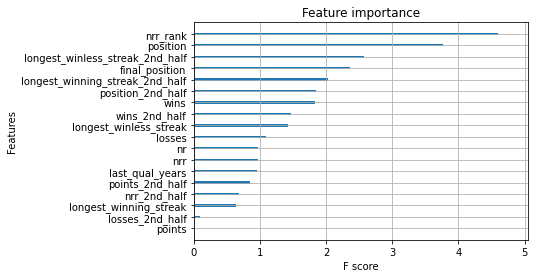

In [13]:
# Run Appendix A before executing the following code
model = XGBClassifier(use_label_encoder = False, eval_metric = 'auc', 
                      colsample_bytree = best_params['colsample_bytree'], gamma = best_params['gamma'], 
                      learning_rate = best_params['learning_rate'], max_depth = int(best_params['max_depth']), 
                      min_child_weight = int(best_params['min_child_weight']), n_estimators = int(best_params['n_estimators']), 
                      reg_alpha = int(best_params['reg_alpha']), reg_lambda = best_params['reg_lambda'], 
                      scale_pos_weight = class_weight, subsample = best_params['subsample'])
model.fit(X_train, y_train)

plot_importance(model, importance_type = 'gain', show_values = False)
plt.show()

## Evaluation

In [14]:
# Make sure that exactly 1 team is predicted as the winner
y_pred = pd.DataFrame(model.predict_proba(X_test), columns = ['lose_prob', 'win_prob']).win_prob
y_pred = np.array(y_pred.groupby(y_pred.index // 8).apply(lambda x: (x == x.max()).astype(int)))

roc_auc_score (train):  0.9223856209150327
roc_auc_score (cross-validation):  0.7392857142857142
roc_auc_score (test):  0.8095238095238093
Best F1-Score: 0.666667 at threshold 0.333612


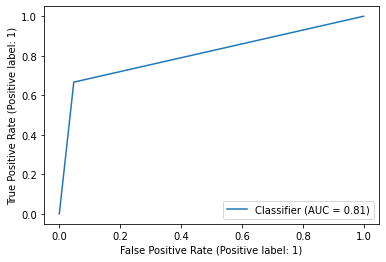

In [15]:
print("roc_auc_score (train): ", metrics.roc_auc_score(y_train, model.predict(X_train)))
scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv = 5)
print("roc_auc_score (cross-validation): ", scores.mean())
print("roc_auc_score (test): ", metrics.roc_auc_score(y_test, y_pred))

precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
f1_score = (2 * precision * recall) / (precision + recall)
max_index = np.nanargmax(f1_score)
print('Best F1-Score: %f at threshold %f' % (f1_score[max_index], thresholds[max_index]))
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

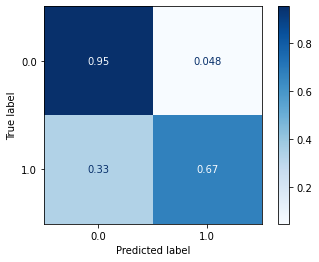

In [16]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'true', cmap = 'Blues')
plt.show()

In [17]:
print(metrics.classification_report(y_train, model.predict(X_train)))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97        68
         1.0       0.73      0.89      0.80         9

    accuracy                           0.95        77
   macro avg       0.86      0.92      0.89        77
weighted avg       0.95      0.95      0.95        77

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        21
         1.0       0.67      0.67      0.67         3

    accuracy                           0.92        24
   macro avg       0.81      0.81      0.81        24
weighted avg       0.92      0.92      0.92        24



In [18]:
# Inspect test set predictions
y_pred = pd.DataFrame(model.predict_proba(X_test), columns = ['lose_prob', 'win_prob'])
temp = pd.concat([data.iloc[-32:-8][['season', 'team']].reset_index(drop = True), y_pred], axis = 1).drop(columns = 'lose_prob')
temp.groupby(temp.season + 1).apply(
    lambda x: x.sort_values('win_prob', ascending = False).set_index(x.reset_index().index + 1)
)[['team', 'win_prob']]

team  win_prob
season                                         
2019   1               Mumbai Indians  0.769336
       2             Rajasthan Royals  0.711925
       3  Royal Challengers Bangalore  0.311162
       4        Kolkata Knight Riders  0.276164
       5          Chennai Super Kings  0.132217
       6                 Punjab Kings  0.108531
       7               Delhi Capitals  0.068513
       8          Sunrisers Hyderabad  0.037828
2020   1               Delhi Capitals  0.452331
       2  Royal Challengers Bangalore  0.340077
       3               Mumbai Indians  0.333612
       4             Rajasthan Royals  0.166149
       5          Sunrisers Hyderabad  0.115144
       6                 Punjab Kings  0.058343
       7        Kolkata Knight Riders  0.041716
       8          Chennai Super Kings  0.020976
2021   1          Chennai Super Kings  0.516542
       2                 Punjab Kings  0.292700
       3          Sunrisers Hyderabad  0.253199
       4  Royal Challengers Bangalore  0.136130
       5               Mumbai Indians  0.122307
       6        Kolkata Knight Riders  0.082302
       7             Rajasthan Royals  0.076649
       8               Delhi Capitals  0.045204

## Testing

In [19]:
# Use full model
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8550382726698293,
              enable_categorical=False, eval_metric='auc',
              gamma=0.4899871975084388, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2852827750578708,
              max_delta_step=0, max_depth=9, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=214, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=4, reg_lambda=0.6523611718923136,
              scale_pos_weight=7.416666666666667, subsample=0.789704910123403,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [20]:
X_new = data.iloc[-8:, 5:-3]
X_new = X_new.drop(columns = 'is_captain_overseas_next')

X_new[match_data_features] = X_new[match_data_features].div(X_new.matches, axis = 0)
X_new[match_data_features_2nd_half] = X_new[match_data_features_2nd_half].div(X_new.matches / 2, axis = 0)

X_new = X_new.drop(columns = 'matches')
X_new

,last_qual_years,final_position,position,wins,losses,nr,points,nrr,nrr_rank,longest_winning_streak,longest_winless_streak,position_2nd_half,wins_2nd_half,losses_2nd_half,nr_2nd_half,points_2nd_half,nrr_2nd_half,nrr_rank_2nd_half,longest_winning_streak_2nd_half,longest_winless_streak_2nd_half
101,1,1,2,0.642857,0.357143,0.0,1.285714,0.455,3,0.357143,0.214286,4,0.571429,0.428571,0.0,1.142857,-0.325,6,0.571429,0.428571
102,1,2,4,0.500000,0.500000,0.0,1.000000,0.587,1,0.142857,0.285714,1,0.714286,0.285714,0.0,1.428571,1.640,1,0.285714,0.142857
103,1,3,1,0.714286,0.285714,0.0,1.428571,0.481,2,0.285714,0.071429,2,0.714286,0.285714,0.0,1.428571,0.509,2,0.428571,0.142857
104,1,4,3,0.642857,0.357143,0.0,1.285714,-0.140,6,0.285714,0.214286,3,0.571429,0.428571,0.0,1.142857,-0.068,5,0.428571,0.285714
105,2,5,5,0.500000,0.500000,0.0,1.000000,0.116,4,0.142857,0.214286,6,0.428571,0.571429,0.0,0.857143,0.162,4,0.285714,0.428571
106,8,6,6,0.428571,0.571429,0.0,0.857143,-0.001,5,0.071429,0.214286,5,0.428571,0.571429,0.0,0.857143,0.262,3,0.142857,0.285714
107,4,7,7,0.357143,0.642857,0.0,0.714286,-0.993,8,0.142857,0.214286,8,0.285714,0.714286,0.0,0.571429,-1.803,8,0.142857,0.428571
108,2,8,8,0.214286,0.785714,0.0,0.428571,-0.545,7,0.071429,0.357143,7,0.285714,0.714286,0.0,0.571429,-0.464,7,0.142857,0.285714


In [21]:
qual = data.iloc[-32:-8].in_next_playoffs.reset_index(drop = True)
qual = qual[qual == 1]
playoff_threshold = y_pred[y_pred.index.isin(qual.index)].win_prob.min()

In [22]:
def stylize(styler):
    styler.set_table_styles([{
        'selector': 'th, td',
        'props': [('text-align', 'left')]
    },
    {
        'selector': 'th:nth-child(1), td:nth-child(1)',
        'props': [('text-align', 'center')]
    }])
    
    cdict = {
        'red': ((0.0,  1.0, 1.0),  
                (playoff_threshold,  1.0, 1.0),
                (thresholds[max_index],  1.0, 1.0),
                (1.0,  0.8, 0.8)),
        
        'green': ((0.0,  0.8, 0.8), 
                  (playoff_threshold,  0.93, 0.93),
                  (thresholds[max_index],  1.0, 1.0),
                  (1.0,  1.0, 1.0)),

        'blue': ((0.0,  0.8, 0.8), 
                 (playoff_threshold,  0.8, 0.8),
                 (thresholds[max_index],  0.8, 0.8),
                 (1.0,  0.8, 0.8))
    }
    cmap = LinearSegmentedColormap('custom_cmap', cdict)

    styler.background_gradient(vmin = expected_outcome.win_prob.min(), vmax = expected_outcome.win_prob.max(), cmap = cmap, 
                               gmap = expected_outcome.win_prob)
    return styler

expected_outcome = pd.concat([data.iloc[-8:, 1].reset_index(drop = True), 
                              pd.DataFrame(model.predict_proba(X_new), columns = ['lose_prob', 'win_prob'])], 
                             axis = 1).sort_values('win_prob', ascending = False, ignore_index = True)

expected_outcome.index += 1
expected_outcome = expected_outcome.rename_axis('#').reset_index()
expected_outcome.drop(columns = 'lose_prob').style.hide_index().pipe(stylize)

#,team,win_prob
1,Kolkata Knight Riders,0.638277
2,Sunrisers Hyderabad,0.289930
3,Royal Challengers Bangalore,0.188517
4,Delhi Capitals,0.178207
5,Rajasthan Royals,0.150495
6,Chennai Super Kings,0.049581
7,Mumbai Indians,0.023234
8,Punjab Kings,0.008429


## Appendix A: Tuning hyperparameters

In [9]:
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 50, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'learning_rate': hp.uniform('learning_rate', 0, 0.3),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1)
}

In [10]:
def objective(space):
    model = XGBClassifier(use_label_encoder = False, eval_metric = 'auc', 
                          colsample_bytree = space['colsample_bytree'], gamma = space['gamma'], 
                          learning_rate = space['learning_rate'], max_depth = int(space['max_depth']), 
                          min_child_weight = int(space['min_child_weight']), n_estimators = int(space['n_estimators']), 
                          reg_alpha = int(space['reg_alpha']), reg_lambda = space['reg_lambda'], 
                          scale_pos_weight = class_weight, subsample = space['subsample'])
    model.fit(X_train, y_train)
    
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', cv = 5)
    print(sorted(scores))
    print('ROC AUC Score: %f ± %f\n' % (scores.mean(), scores.std()))
    return {'loss': -scores.mean(), 'status': STATUS_OK }

In [11]:
trials = Trials()
best_params = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials)

[0.34615384615384615, 0.5, 0.5, 0.5714285714285714, 0.596153846153846]                                                 
ROC AUC Score: 0.502747 ± 0.087153                                                                                     

[0.5, 0.5, 0.5, 0.5, 0.5]                                                                                              
ROC AUC Score: 0.500000 ± 0.000000                                                                                     

[0.5, 0.5, 0.5, 0.5, 0.5]                                                                                              
ROC AUC Score: 0.500000 ± 0.000000                                                                                     

[0.5, 0.5, 0.5, 0.5, 0.5]                                                                                              
ROC AUC Score: 0.500000 ± 0.000000                                                                                     

[0.5, 0.5, 0.5, 0.5, 0.5]           

ROC AUC Score: 0.500000 ± 0.000000                                                                                     

[0.32142857142857145, 0.5357142857142857, 0.5961538461538461, 0.6346153846153846, 0.9285714285714285]                  
ROC AUC Score: 0.603297 ± 0.195373                                                                                     

[0.5, 0.5, 0.5, 0.6428571428571429, 0.8214285714285714]                                                                
ROC AUC Score: 0.592857 ± 0.126974                                                                                     

[0.4807692307692308, 0.49999999999999994, 0.5357142857142857, 0.6071428571428572, 0.7857142857142857]                  
ROC AUC Score: 0.581868 ± 0.110676                                                                                     

[0.35714285714285715, 0.576923076923077, 0.6346153846153846, 0.6607142857142857, 0.7857142857142857]                   
ROC AUC Score: 0.603022 ± 0.140599  

[0.5, 0.5714285714285714, 0.7115384615384615, 0.7142857142857143, 0.8571428571428571]                                  
ROC AUC Score: 0.670879 ± 0.124356                                                                                     

[0.4423076923076923, 0.5769230769230769, 0.6428571428571428, 0.75, 0.8571428571428572]                                 
ROC AUC Score: 0.653846 ± 0.142381                                                                                     

[0.4807692307692308, 0.5, 0.5769230769230769, 0.6428571428571428, 0.7857142857142857]                                  
ROC AUC Score: 0.597253 ± 0.110487                                                                                     

[0.5384615384615384, 0.6071428571428572, 0.6153846153846154, 0.625, 0.9285714285714286]                                
ROC AUC Score: 0.662912 ± 0.136286                                                                                     

[0.4642857142857143, 0.5384615384615

In [12]:
best_params

{'colsample_bytree': 0.8550382726698293,
 'gamma': 0.4899871975084388,
 'learning_rate': 0.2852827750578708,
 'max_depth': 9.0,
 'min_child_weight': 3.0,
 'n_estimators': 214.0,
 'reg_alpha': 4.0,
 'reg_lambda': 0.6523611718923136,
 'subsample': 0.789704910123403}